In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from itables import show
import os
import glob
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
tqdm.pandas()
files = sorted(glob.glob("data/classified/climate_tweets_*.csv"))
print(files)
pd.set_option('display.max_colwidth', -1)

['data/classified/climate_tweets_2006.csv', 'data/classified/climate_tweets_2007.csv', 'data/classified/climate_tweets_2008.csv', 'data/classified/climate_tweets_2009.csv', 'data/classified/climate_tweets_2010.csv', 'data/classified/climate_tweets_2011.csv', 'data/classified/climate_tweets_2012.csv', 'data/classified/climate_tweets_2013.csv', 'data/classified/climate_tweets_2014.csv', 'data/classified/climate_tweets_2015.csv', 'data/classified/climate_tweets_2016.csv', 'data/classified/climate_tweets_2017.csv', 'data/classified/climate_tweets_2018.csv', 'data/classified/climate_tweets_2019.csv', 'data/classified/climate_tweets_2020.csv']


<ipython-input-1-31bef66501b7>:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
%%time
df = pd.concat(pd.read_csv(f, sep=";", engine="c", lineterminator="\n") for f in tqdm(files))

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 13min 54s, sys: 1min 44s, total: 15min 38s
Wall time: 22min 15s


In [3]:
print(len(df))

32335076


In [4]:
%%time
df.timestamp = pd.to_datetime(df.timestamp)
df.index = df.timestamp

CPU times: user 1min 26s, sys: 2.91 s, total: 1min 29s
Wall time: 1min 28s


In [5]:
daycounts = df.timestamp.resample("D").count()
daycounts[daycounts == 0].index

DatetimeIndex(['2006-06-07', '2006-06-08', '2006-06-09', '2006-06-10',
               '2006-06-11', '2006-06-12', '2006-06-13', '2006-06-14',
               '2006-06-15', '2006-06-16',
               ...
               '2010-03-15', '2010-03-16', '2010-03-17', '2010-03-18',
               '2010-03-19', '2010-03-20', '2010-03-21', '2019-08-29',
               '2020-02-17', '2020-02-18'],
              dtype='datetime64[ns]', name='timestamp', length=230, freq=None)

In [6]:
df.columns

Index(['username', 'fullname', 'user_id', 'tweet_id', 'tweet_url', 'timestamp',
       'timestamp_epochs', 'replies', 'retweets', 'likes', 'is_retweet',
       'retweeter_username', 'retweeter_userid', 'retweet_id', 'text', 'html',
       'text_with_emoji', 'neg', 'neu', 'pos', 'compound'],
      dtype='object')

In [7]:
df.timestamp.resample("M").count().median()

159389.5

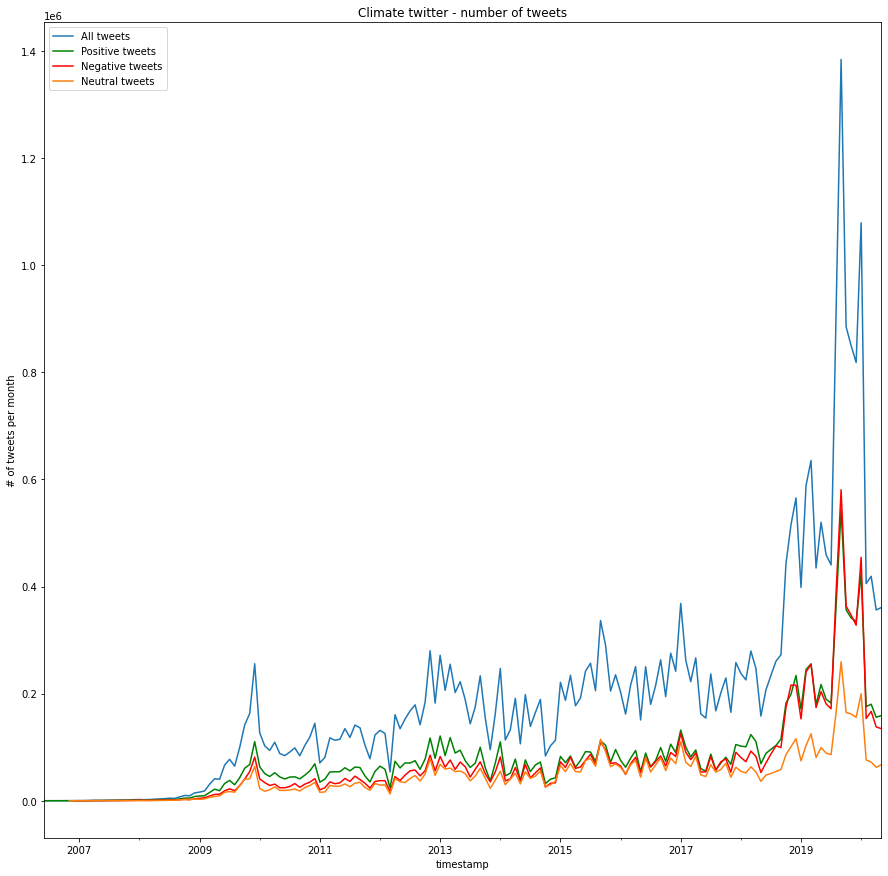

In [8]:
df.timestamp.resample("M").count().plot(figsize=(15,15), title="Climate twitter - number of tweets")
df.timestamp[df["compound"] > 0.05].resample("M").count().plot(color='g')
df.timestamp[df["compound"] < -0.05].resample("M").count().plot(color='r')
df.timestamp[df["compound"].between(-.05, .05)].resample("M").count().plot()
plt.legend(["All tweets", "Positive tweets", "Negative tweets", "Neutral tweets"])
plt.ylabel("# of tweets per month")
plt.show()

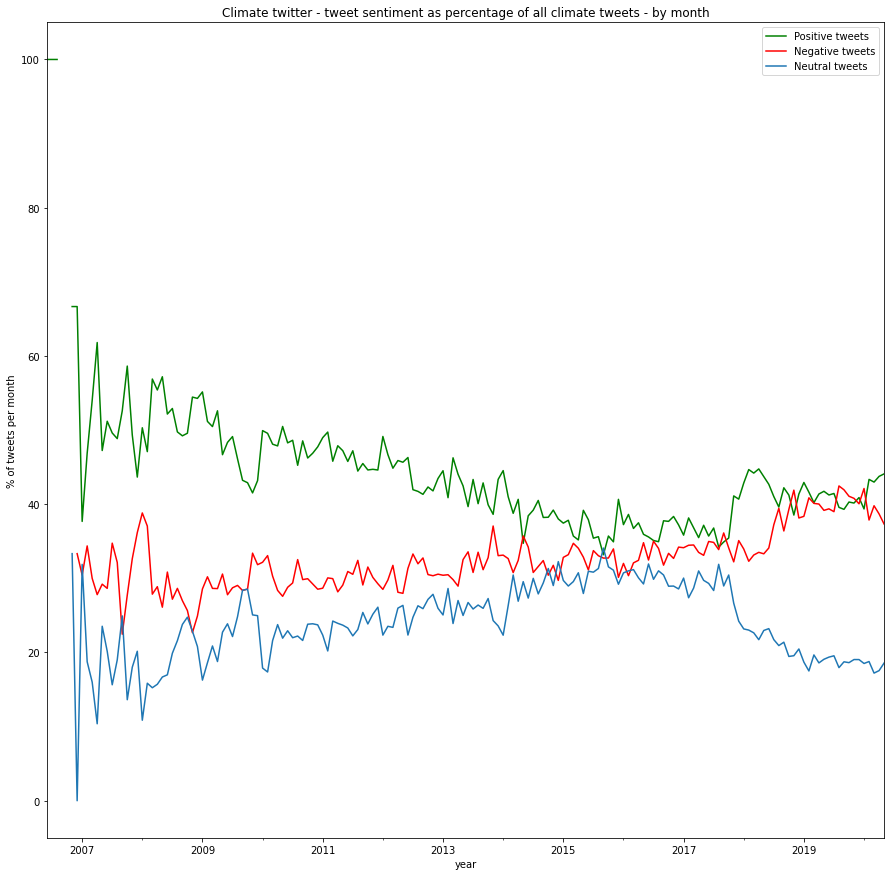

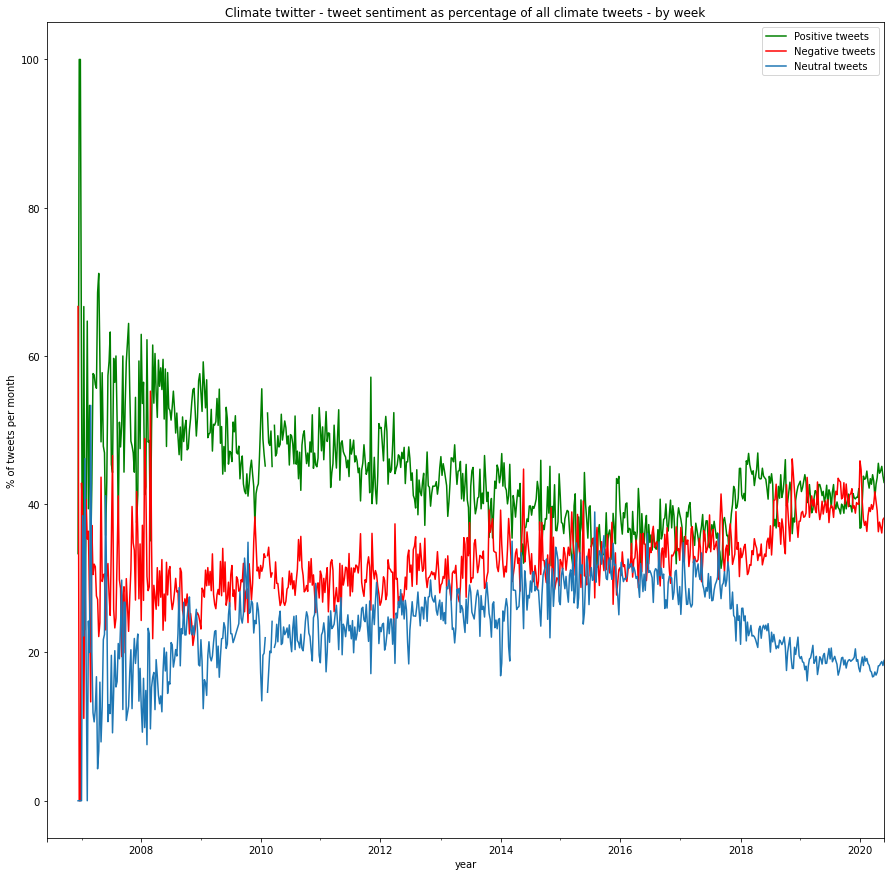

In [9]:
#et_by_month_pc = et_by_month.count() / by_month.count() * 100

all_tweets_monthly = df.timestamp.resample("M").count()
pos_tweets = df.timestamp[df["compound"] > 0.05].resample("M").count()
pos_tweets_pc = pos_tweets / all_tweets_monthly * 100
neg_tweets = df.timestamp[df["compound"] < -0.05].resample("M").count()
neg_tweets_pc = neg_tweets / all_tweets_monthly * 100
neutral_tweets = df.timestamp[df["compound"].between(-.05, .05)].resample("M").count()
neutral_tweets_pc = neutral_tweets / all_tweets_monthly * 100

pos_tweets_pc.plot(figsize=(15,15), title="Climate twitter - tweet sentiment as percentage of all climate tweets - by month",color="g")
neg_tweets_pc.plot(color='r')
neutral_tweets_pc.plot()
plt.legend(["Positive tweets", "Negative tweets", "Neutral tweets"])
plt.xlabel("year")
plt.ylabel("% of tweets per month")
plt.show()


#et_by_month_pc = et_by_month.count() / by_month.count() * 100
all_tweets_monthly = df.timestamp.resample("W").count()
pos_tweets = df.timestamp[df["compound"] > 0.05].resample("W").count()
pos_tweets_pc = pos_tweets / all_tweets_monthly * 100
neg_tweets = df.timestamp[df["compound"] < -0.05].resample("W").count()
neg_tweets_pc = neg_tweets / all_tweets_monthly * 100
neutral_tweets = df.timestamp[df["compound"].between(-.05, .05)].resample("W").count()
neutral_tweets_pc = neutral_tweets / all_tweets_monthly * 100

pos_tweets_pc.plot(figsize=(15,15), title="Climate twitter - tweet sentiment as percentage of all climate tweets - by week",color="g")
neg_tweets_pc.plot(color='r')
neutral_tweets_pc.plot()
plt.legend(["Positive tweets", "Negative tweets", "Neutral tweets"])
plt.xlabel("year")
plt.ylabel("% of tweets per month")
plt.show()

In [10]:
%%time
def display_filtered_df(df, pattern, n=5000, extracols = []):
    if len(df) < n:
        filtered_df = df
    else:
        filtered_df = df.sample(n)
    filtered_df["text_with_emoji_formatted"] = filtered_df.text_with_emoji.str.replace(pattern, lambda x: "<b>" + x.group() + "</b>", case=False)
    show(filtered_df[["text_with_emoji_formatted", "compound"] + extracols],
        order=[[2, 'desc']],
        orderClasses=False,
        createdRow="""function( row, data, dataIndex ) {
          if (data[2] > 0) {
            $(row).css('background-color', 'rgba(0,255,0,.2)');
          } else if (data[2] == 0) {
            $(row).css('background-color', 'rgba(0,0,255,.2)');
          } else {
            $(row).css('background-color', 'rgba(255,0,0,.2)');
          }
        }""", scrollY="800px", scrollCollapse=True, paging=False, columnDefs=[{"width": "120px", "targets": "_all"}])

pattern = r"global.?warming|climate.?chang|sea.?level.?ris|rising.?sea.?level|climate.?crisis|climate.?action|extreme.?weather|biodiversity|IPCC|Paris.?accord"
display_filtered_df(df, pattern)

<timed exec>:6: FutureWarning: The default value of regex will change from True to False in a future version.


<IPython.core.display.Javascript object>

,text_with_emoji_formatted,compound
timestamp,,


CPU times: user 18.3 s, sys: 6.72 s, total: 25 s
Wall time: 25 s


<AxesSubplot:title={'center':'Mean sentiment per month'}, xlabel='timestamp'>

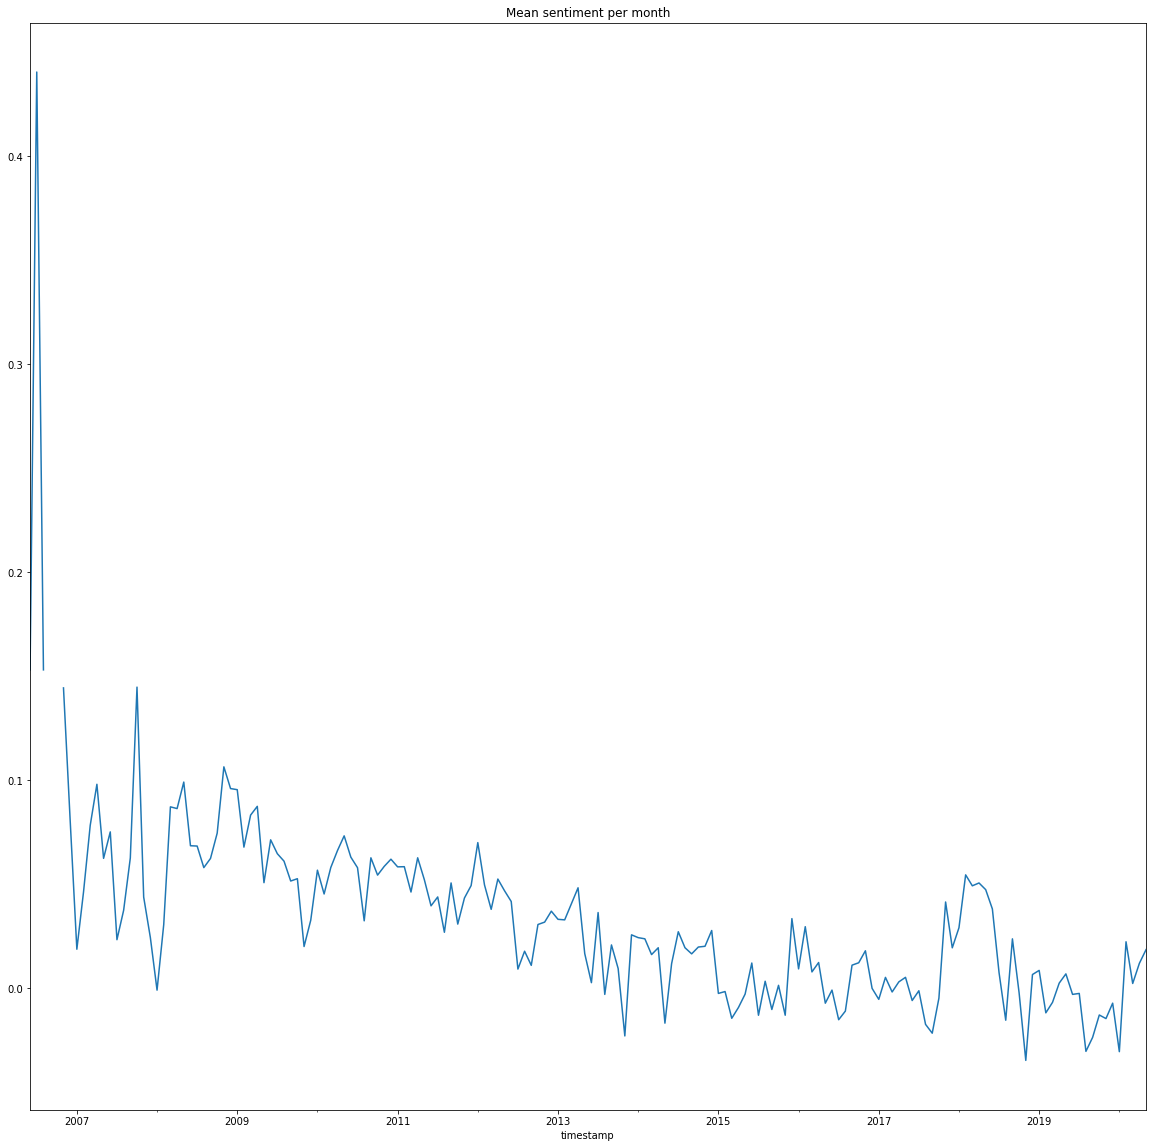

In [11]:
df["compound"].resample("M").mean().plot(figsize=(20,20), title="Mean sentiment per month")

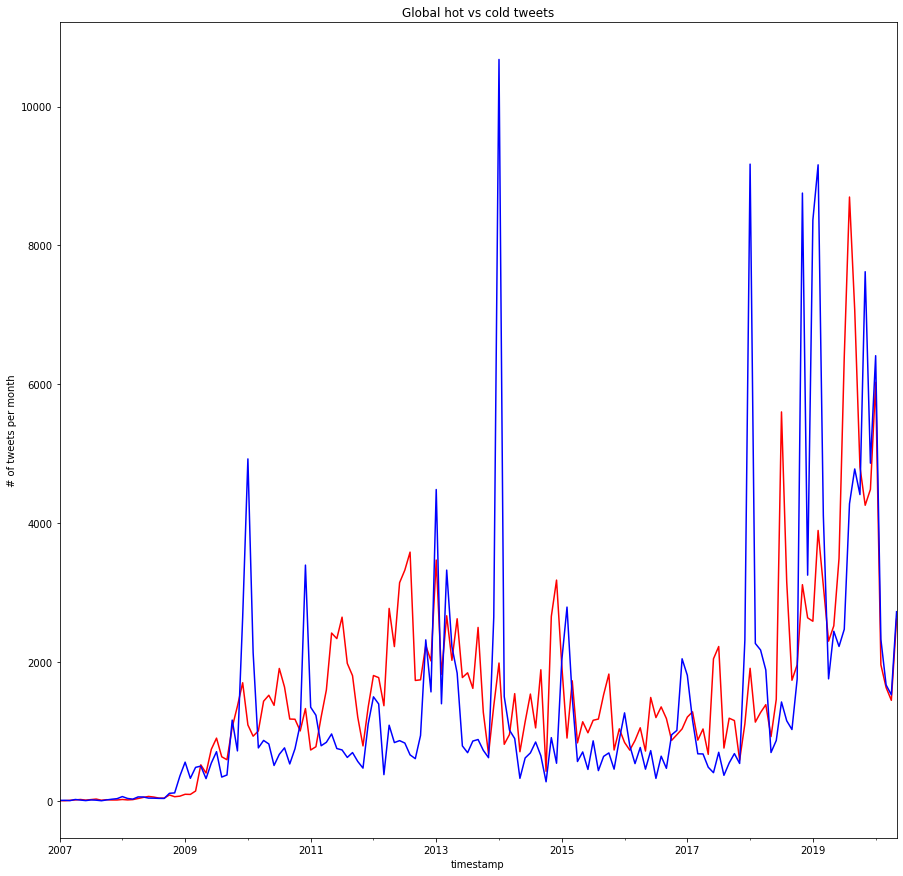

In [12]:
df.timestamp[df.text.str.contains(r"\bhot\b", na=False)].resample("M").count().plot(figsize=(15, 15), title="Global hot vs cold tweets", color="r")
df.timestamp[df.text.str.contains(r"\bcold\b", na=False)].resample("M").count().plot(color="b")
plt.ylabel("# of tweets per month")
plt.show()

In [13]:
print(df.columns)
display_filtered_df(df[df.likes > 2e5], pattern, 500, ["username", "likes"])

Index(['username', 'fullname', 'user_id', 'tweet_id', 'tweet_url', 'timestamp',
       'timestamp_epochs', 'replies', 'retweets', 'likes', 'is_retweet',
       'retweeter_username', 'retweeter_userid', 'retweet_id', 'text', 'html',
       'text_with_emoji', 'neg', 'neu', 'pos', 'compound'],
      dtype='object')


<timed exec>:6: FutureWarning: The default value of regex will change from True to False in a future version.
<timed exec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,text_with_emoji_formatted,compound,username,likes
timestamp,,,,


In [14]:
display_filtered_df(df[df.username == "realDonaldTrump"], pattern)

<timed exec>:6: FutureWarning: The default value of regex will change from True to False in a future version.
<timed exec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,text_with_emoji_formatted,compound
timestamp,,


In [15]:
%%time
pattern = r"fake|not real|isn'?t real|doesn'?t exist|hoax|propaganda|conspiracy"
deniers = df[df.text.str.contains(pattern, case=False, na=False)]
print(len(deniers))
display_filtered_df(deniers, pattern)

<timed exec>:6: FutureWarning: The default value of regex will change from True to False in a future version.


942970


,text_with_emoji_formatted,compound
timestamp,,


CPU times: user 11min 2s, sys: 193 ms, total: 11min 3s
Wall time: 11min 3s


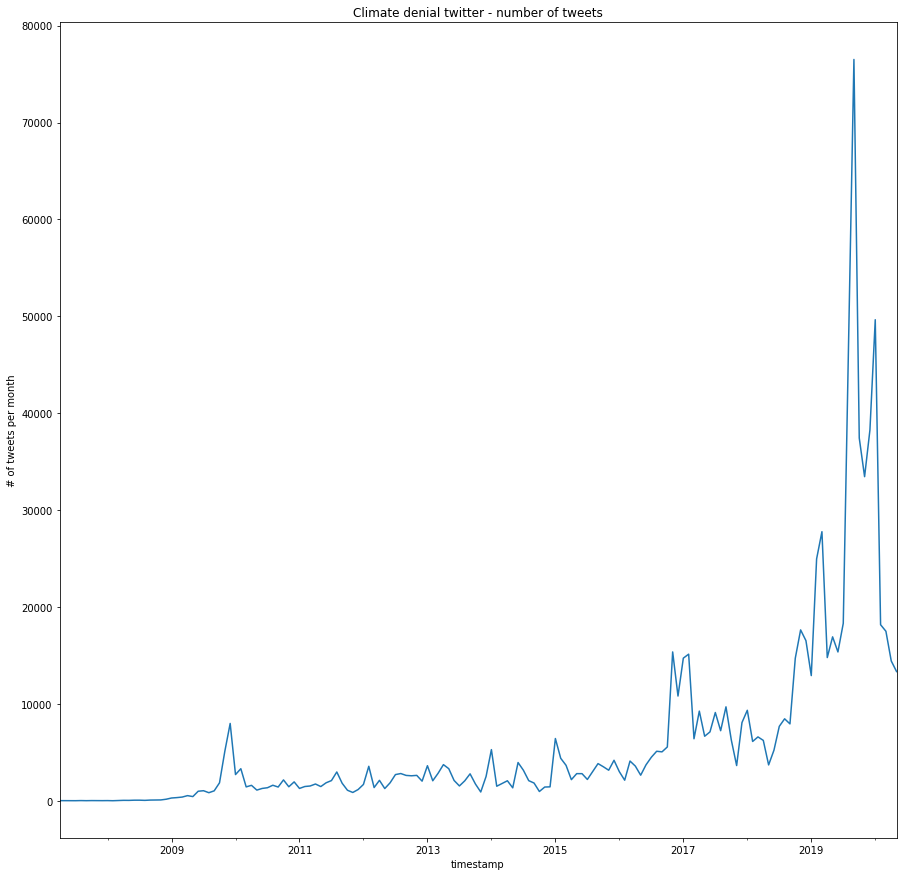

In [16]:
deniers.timestamp.resample("M").count().plot(figsize=(15,15), title="Climate denial twitter - number of tweets")
plt.ylabel("# of tweets per month")
plt.show()

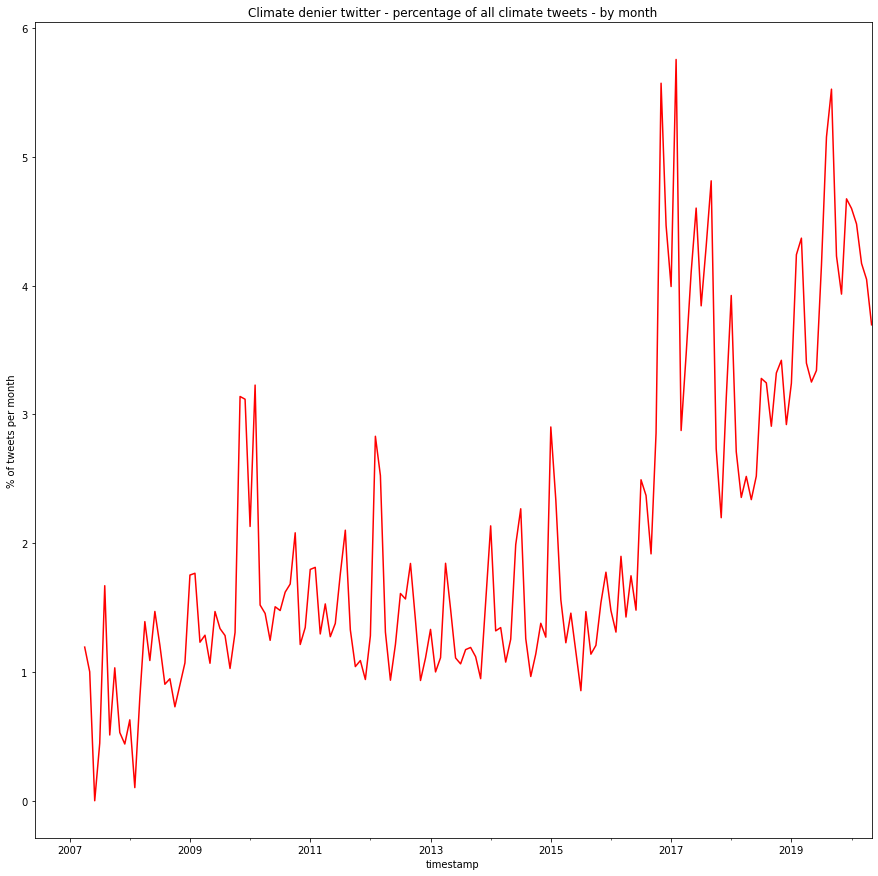

In [17]:
all_tweets_monthly = df.timestamp.resample("M").count()
denier_tweets = deniers.timestamp.resample("M").count()
denier_tweet_pc = denier_tweets / all_tweets_monthly * 100

denier_tweet_pc.plot(figsize=(15,15), title="Climate denier twitter - percentage of all climate tweets - by month",color="r")
plt.ylabel("% of tweets per month")
plt.show()

In [18]:
#%%time
# Save datasets of unique users and ids for bot scoring. Takes ~13min
#df[["username", "user_id"]].value_counts().to_csv("data/users.csv")

In [19]:
botscores = pd.read_csv("data/botscores.csv")
botscores

,user_id,screen_name,prob_bot,n_tweets
0,731164510489313280,GCCThinkActTank,0.368905,63791
1,330509973,annemariayritys,0.007271,47821
2,176470818,Vandahmier,0.159065,41108
3,1079911297,NaN,NaN,39807
4,2365497828,ZEROCO2_,0.001946,31124
...,...,...,...,...
313225,1305381488,KyleJDeFreitas,0.001114,14
313226,947635931590287361,NaN,NaN,14
313227,3376148665,blokeinthecrowd,0.001657,14
313228,3270003739,_GoSpace,0.029052,14


In [21]:
%%time
merged = pd.merge(df, botscores, on="user_id")
merged

CPU times: user 2min 57s, sys: 7.02 s, total: 3min 4s
Wall time: 3min 2s


,username,fullname,user_id,tweet_id,tweet_url,timestamp,timestamp_epochs,replies,retweets,likes,...,text,html,text_with_emoji,neg,neu,pos,compound,screen_name,prob_bot,n_tweets
0,eversion,Rob Annable,46673,1893063,/eversion/status/1893063,2006-12-31 10:47:25,1167562045,0,0,0,...,Warmer climate. Wider grain. Easier to cut. Thank you global warming.,"<p class=""TweetTextSize js-tweet-text tweet-text"" data-aria-label-part=""0"" lang=""en"">Warmer climate. Wider grain. Easier to cut. Thank you <strong>global warming</strong>.</p>",Warmer climate. Wider grain. Easier to cut. Thank you global warming .,0.115,0.385,0.500,0.7184,eversion,0.004161,14
1,eversion,Rob Annable,46673,1893063,/eversion/status/1893063,2006-12-31 10:47:25,1167562045,0,0,0,...,Warmer climate. Wider grain. Easier to cut. Thank you global warming.,"<p class=""TweetTextSize js-tweet-text tweet-text"" data-aria-label-part=""0"" lang=""en"">Warmer climate. Wider grain. Easier to cut. Thank you <strong>global warming</strong>.</p>",Warmer climate. Wider grain. Easier to cut. Thank you global warming .,0.115,0.385,0.500,0.7184,eversion,0.004161,14
2,eversion,Rob Annable,46673,826756380,/eversion/status/826756380,2008-06-04 11:43:26,1212579806,0,0,0,...,Failing to blog images from Birmingham's Climate Change festival because of broken iPhone camera,"<p class=""TweetTextSize js-tweet-text tweet-text"" data-aria-label-part=""0"" lang=""en"">Failing to blog images from Birmingham's <strong>Climate Change</strong> festival because of broken iPhone camera</p>",Failing to blog images from Birmingham's Climate Change festival because of broken iPhone camera,0.311,0.534,0.155,-0.4939,eversion,0.004161,14
3,eversion,Rob Annable,46673,812123666,/eversion/status/812123666,2008-05-15 17:36:29,1210872989,0,0,0,...,Wondering what I'm going to do with the stall I've been offered at the Birmingham Climate Change Festival,"<p class=""TweetTextSize js-tweet-text tweet-text"" data-aria-label-part=""0"" lang=""en"">Wondering what I'm going to do with the stall I've been offered at the Birmingham <strong>Climate Change</strong> Festival</p>",Wondering what I'm going to do with the stall I've been offered at the Birmingham Climate Change Festival,0.086,0.762,0.152,0.3400,eversion,0.004161,14
4,eversion,Rob Annable,46673,5534149643,/eversion/status/5534149643,2009-11-08 15:53:14,1257695594,0,0,0,...,"Kids on climate change and low energy buildings: ""Dad, is that why you've been working so much? Because you've got to save the earth?""","<p class=""TweetTextSize js-tweet-text tweet-text"" data-aria-label-part=""0"" lang=""en"">Kids on <strong>climate change</strong> and low energy buildings: ""Dad, is that why you've been working so much? Because you've got to save the earth?""</p>","Kids on climate change and low energy buildings: ""Dad, is that why you've been working so much? Because you've got to save the earth?""",0.073,0.730,0.197,0.5514,eversion,0.004161,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19663644,TheHipHopMayor,Likwid Nomana,1206256844827697152,1213523146885779456,/TheHipHopMayor/status/1213523146885779456,2020-01-04 18:10:39,1578161439,0,0,0,...,We had #20plentyHipHopSessions Ko Tlhageng yesterday at Ventersdorp. #Blacktwitter #ClimateChange #IranWar #hiphop #music #beats #RhymeFestZApic.twitter.com/wXkllYlPSM,"<p class=""TweetTextSize js-tweet-text tweet-text"" data-aria-label-part=""0"" lang=""in"">We had <a class=""twitter-hashtag pretty-link js-nav"" data-query-source=""hashtag_click"" dir=""ltr"" href=""/hashtag/20plentyHipHopSessions?src=hash""><s>#</s><b>20plentyHipHopSessions</b></a> Ko Tlhageng yesterday at Ventersdorp. <a class=""twitter-hashtag pretty-link js-nav"" data-query-source=""hashtag_click"" dir=""ltr"" href=""/hashtag/Blacktwitter?src=hash""><s>#</s><b>Blacktwitter</b></a> <a class=""twitter-hashtag pretty-link js-nav"" data-query-source=""hashtag_click"" dir=""ltr"" href=""/hashtag/ClimateChange?src=hash""

In [25]:
bot_tweets = merged[merged.prob_bot > .5]
human_tweets = merged[merged.prob_bot < .5]

In [30]:
bot_tweets.index = bot_tweets.timestamp
human_tweets.index = human_tweets.timestamp

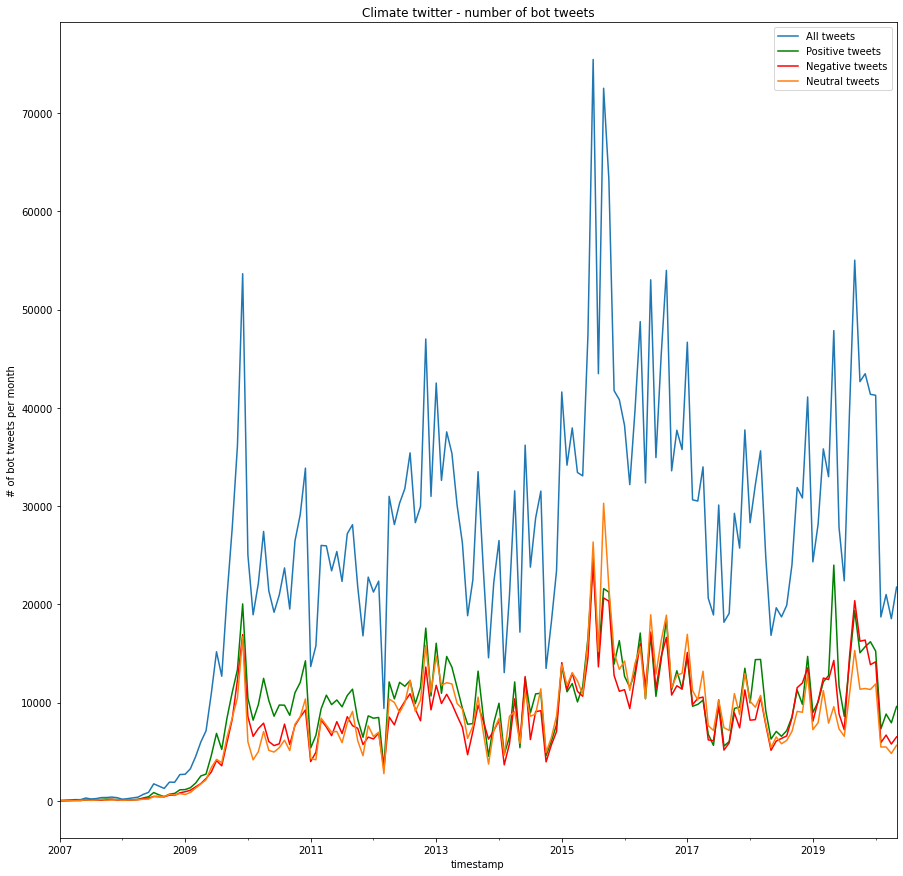

In [32]:
bot_tweets.timestamp.resample("M").count().plot(figsize=(15,15), title="Climate twitter - number of bot tweets")
bot_tweets.timestamp[bot_tweets["compound"] > 0.05].resample("M").count().plot(color='g')
bot_tweets.timestamp[bot_tweets["compound"] < -0.05].resample("M").count().plot(color='r')
bot_tweets.timestamp[bot_tweets["compound"].between(-.05, .05)].resample("M").count().plot()
plt.legend(["All tweets", "Positive tweets", "Negative tweets", "Neutral tweets"])
plt.ylabel("# of bot tweets per month")
plt.show()

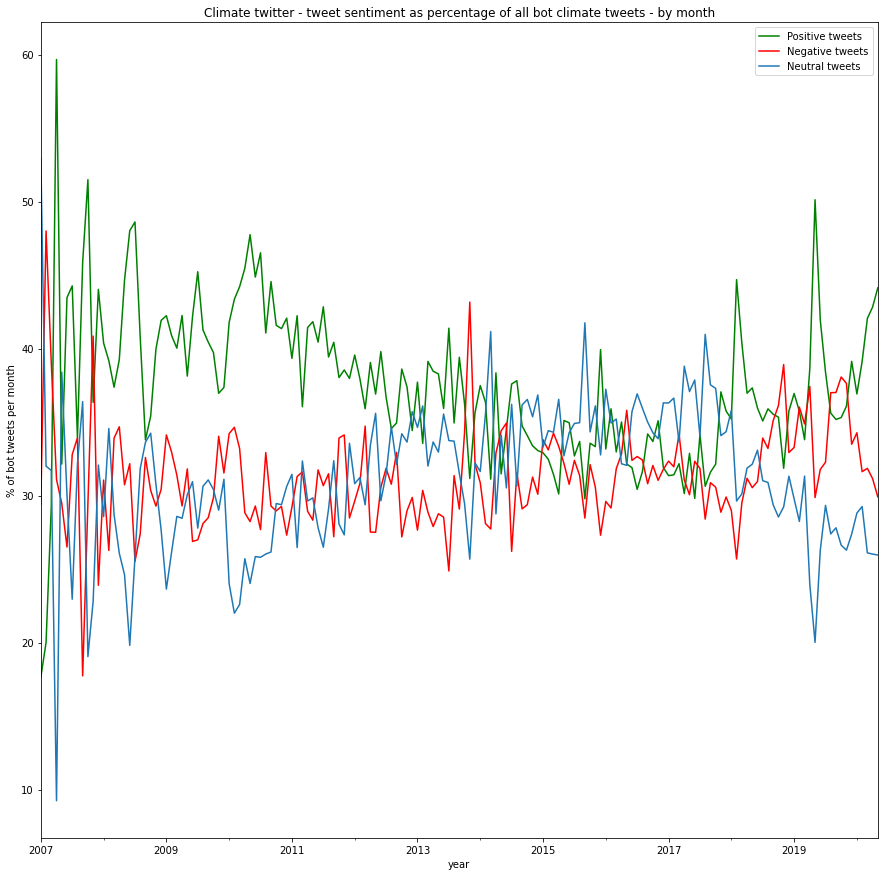

In [33]:
all_tweets_monthly = bot_tweets.timestamp.resample("M").count()
pos_tweets = bot_tweets.timestamp[bot_tweets["compound"] > 0.05].resample("M").count()
pos_tweets_pc = pos_tweets / all_tweets_monthly * 100
neg_tweets = bot_tweets.timestamp[bot_tweets["compound"] < -0.05].resample("M").count()
neg_tweets_pc = neg_tweets / all_tweets_monthly * 100
neutral_tweets = bot_tweets.timestamp[bot_tweets["compound"].between(-.05, .05)].resample("M").count()
neutral_tweets_pc = neutral_tweets / all_tweets_monthly * 100

pos_tweets_pc.plot(figsize=(15,15), title="Climate twitter - tweet sentiment as percentage of all bot climate tweets - by month",color="g")
neg_tweets_pc.plot(color='r')
neutral_tweets_pc.plot()
plt.legend(["Positive tweets", "Negative tweets", "Neutral tweets"])
plt.xlabel("year")
plt.ylabel("% of bot tweets per month")
plt.show()

In [34]:
pattern = r"global.?warming|climate.?chang|sea.?level.?ris|rising.?sea.?level|climate.?crisis|climate.?action|extreme.?weather|biodiversity|IPCC|Paris.?accord"
display_filtered_df(bot_tweets, pattern)

<timed exec>:6: FutureWarning: The default value of regex will change from True to False in a future version.


,text_with_emoji_formatted,compound
timestamp,,


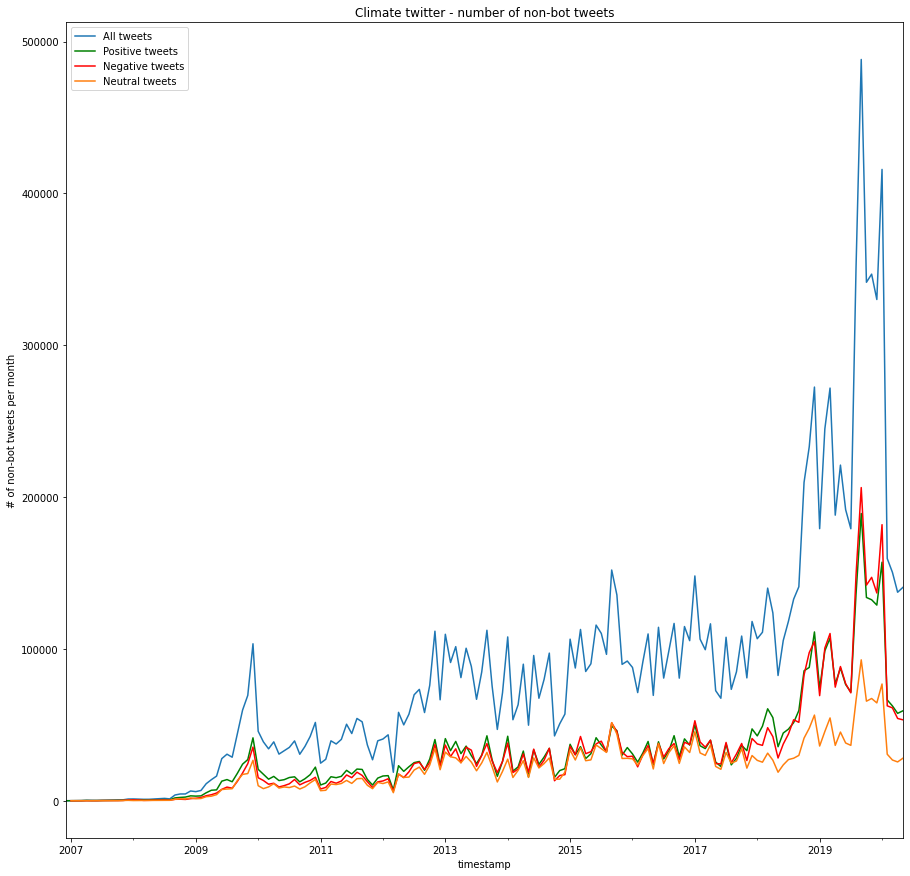

In [37]:
human_tweets.timestamp.resample("M").count().plot(figsize=(15,15), title="Climate twitter - number of non-bot tweets")
human_tweets.timestamp[human_tweets["compound"] > 0.05].resample("M").count().plot(color='g')
human_tweets.timestamp[human_tweets["compound"] < -0.05].resample("M").count().plot(color='r')
human_tweets.timestamp[human_tweets["compound"].between(-.05, .05)].resample("M").count().plot()
plt.legend(["All tweets", "Positive tweets", "Negative tweets", "Neutral tweets"])
plt.ylabel("# of non-bot tweets per month")
plt.show()

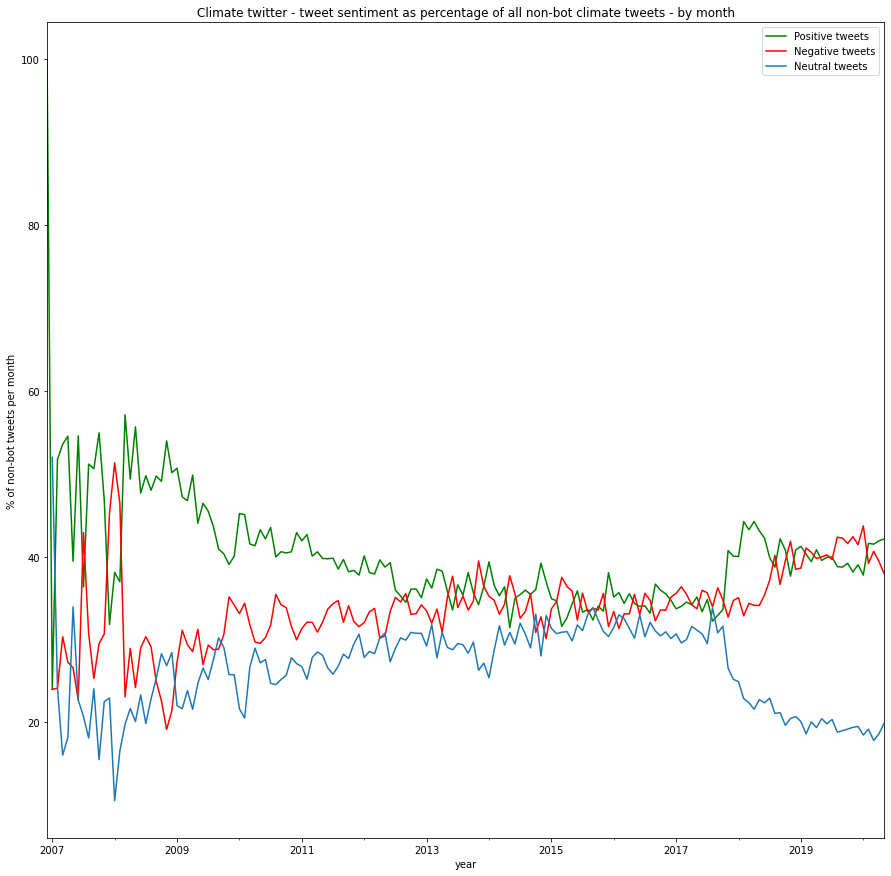

In [38]:
all_tweets_monthly = human_tweets.timestamp.resample("M").count()
pos_tweets = human_tweets.timestamp[human_tweets["compound"] > 0.05].resample("M").count()
pos_tweets_pc = pos_tweets / all_tweets_monthly * 100
neg_tweets = human_tweets.timestamp[human_tweets["compound"] < -0.05].resample("M").count()
neg_tweets_pc = neg_tweets / all_tweets_monthly * 100
neutral_tweets = human_tweets.timestamp[human_tweets["compound"].between(-.05, .05)].resample("M").count()
neutral_tweets_pc = neutral_tweets / all_tweets_monthly * 100

pos_tweets_pc.plot(figsize=(15,15), title="Climate twitter - tweet sentiment as percentage of all non-bot climate tweets - by month",color="g")
neg_tweets_pc.plot(color='r')
neutral_tweets_pc.plot()
plt.legend(["Positive tweets", "Negative tweets", "Neutral tweets"])
plt.xlabel("year")
plt.ylabel("% of non-bot tweets per month")
plt.show()

In [40]:
%%time
deniers_merged = pd.merge(deniers, botscores, on="user_id")
deniers_merged

CPU times: user 3.87 s, sys: 59 ms, total: 3.93 s
Wall time: 3.92 s


,username,fullname,user_id,tweet_id,tweet_url,timestamp,timestamp_epochs,replies,retweets,likes,...,text,html,text_with_emoji,neg,neu,pos,compound,screen_name,prob_bot,n_tweets
0,jhayrocas,Jay,926061,543666102,/jhayrocas/status/543666102,2007-12-29 13:00:26,1198933226,0,0,0,...,"who said global warming is a hoax, it's december and i'm sweating in silang!","<p class=""TweetTextSize js-tweet-text tweet-text"" data-aria-label-part=""0"" lang=""en"">who said <strong>global warming</strong> is a hoax, it's december and i'm sweating in silang!</p>","who said global warming is a hoax, it's december and i'm sweating in silang!",0.150,0.750,0.100,-0.2003,jhayrocas,0.000852,15
1,Rubenerd,Ruben Schade 🔰,875971,520722232,/Rubenerd/status/520722232,2007-12-21 10:39:15,1198233555,0,0,0,...,@IntoYourHead I heard from Hank that Global Warming is a conspiracy cooked up by polar bears or something to stop artic exploration!,"<p class=""TweetTextSize js-tweet-text tweet-text"" data-aria-label-part=""0"" lang=""en""><a class=""twitter-atreply pretty-link js-nav"" data-mentioned-user-id=""49491971"" dir=""ltr"" href=""/intoyourhead""><s>@</s><b>IntoYourHead</b></a> I heard from Hank that <strong>Global Warming</strong> is a conspiracy cooked up by polar bears or something to stop artic exploration!</p>",@IntoYourHead I heard from Hank that Global Warming is a conspiracy cooked up by polar bears or something to stop artic exploration!,0.215,0.657,0.128,-0.5255,Rubenerd,0.023427,35
2,Rubenerd,Ruben Schade 🔰,875971,520722232,/Rubenerd/status/520722232,2007-12-21 10:39:15,1198233555,0,0,0,...,@IntoYourHead I heard from Hank that Global Warming is a conspiracy cooked up by polar bears or something to stop artic exploration!,"<p class=""TweetTextSize js-tweet-text tweet-text"" data-aria-label-part=""0"" lang=""en""><a class=""twitter-atreply pretty-link js-nav"" data-mentioned-user-id=""49491971"" dir=""ltr"" href=""/intoyourhead""><s>@</s><b>IntoYourHead</b></a> I heard from Hank that <strong>Global Warming</strong> is a conspiracy cooked up by polar bears or something to stop artic exploration!</p>",@IntoYourHead I heard from Hank that Global Warming is a conspiracy cooked up by polar bears or something to stop artic exploration!,0.215,0.657,0.128,-0.5255,Rubenerd,0.023427,35
3,Rubenerd,Ruben Schade 🔰,875971,800304651,/Rubenerd/status/800304651,2008-04-30 12:16:12,1209557772,0,0,0,...,"@ons I've almost finished my report on the ""Oil companies discrediting global warming to save their business"" conspiracy theory","<p class=""TweetTextSize js-tweet-text tweet-text"" data-aria-label-part=""0"" lang=""en""><a class=""twitter-atreply pretty-link js-nav"" data-mentioned-user-id=""219275799"" dir=""ltr"" href=""/ONS""><s>@</s><b>ons</b></a> I've almost finished my report on the ""Oil companies discrediting <strong>global warming</strong> to save their business"" conspiracy theory</p>","@ons I've almost finished my report on the ""Oil companies discrediting global warming to save their business"" conspiracy theory",0.140,0.661,0.198,0.1027,Rubenerd,0.023427,35
4,conservatweet,conservatweet,9335232,490757572,/conservatweet/status/490757572,2007-12-11 17:41:10,1197394870,0,0,0,...,[Hot Air]: Max Mayfield destroys Democrats’ global warming conspiracy: Imperfect storm. http://tinyurl.com/2vlhas,"<p class=""TweetTextSize js-tweet-text tweet-text"" data-aria-label-part=""0"" lang=""en"">[Hot Air]: Max Mayfield destroys Democrats’ <strong>global warming</strong> conspiracy: Imperfect storm. http://tinyurl.com/2vlhas</p>",[Hot Air]: Max Mayfield destroys Democrats’ global warming conspiracy: Imperfect storm. http://tinyurl.com/2vlhas,0.492,0.423,0.085,-0.8271,NaN,NaN,2265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511151,MisterTimmr1,Old Timmr,4879535764,1212176671731634176,/MisterTimmr1/status/1212176671731634176,2020-01-01 01:00:14,1577840414,0,0,0,...,@LindseyGrahamSC also said climate change was real. He's a flake or

In [41]:
deniers_merged.index = deniers_merged.timestamp

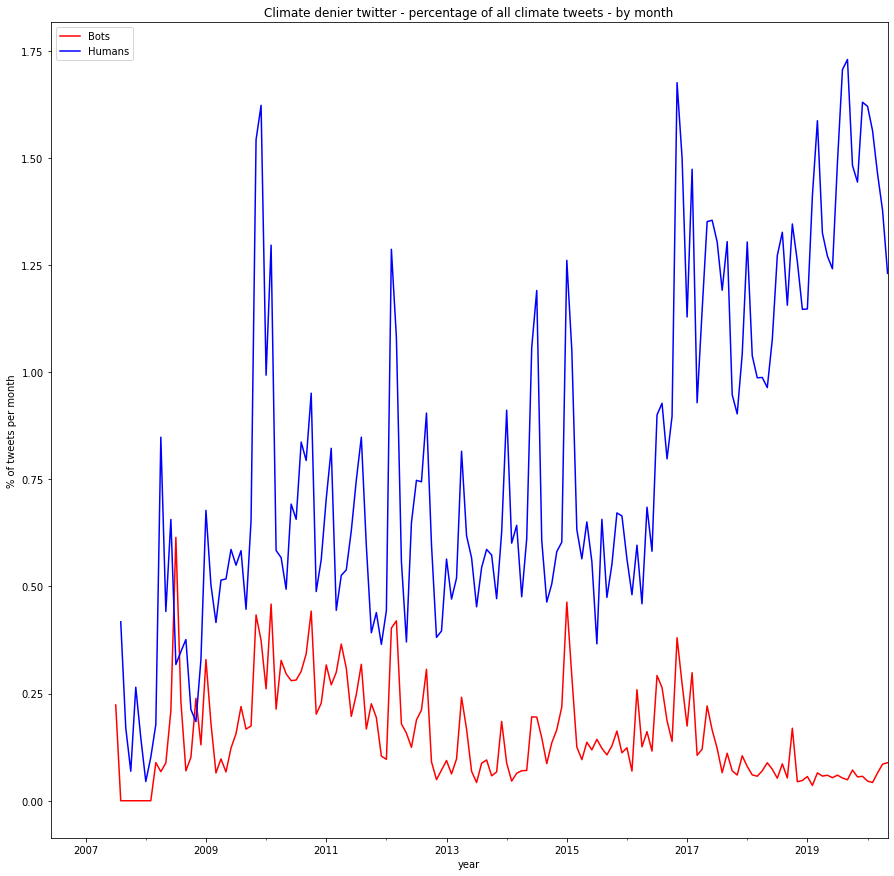

In [45]:
all_tweets_monthly = df.timestamp.resample("M").count()
bot_denier_tweets = deniers_merged[deniers_merged.prob_bot > .5].timestamp.resample("M").count()
human_denier_tweets = deniers_merged[deniers_merged.prob_bot < .5].timestamp.resample("M").count()
bot_denier_tweet_pc = bot_denier_tweets / all_tweets_monthly * 100
human_denier_tweet_pc = human_denier_tweets / all_tweets_monthly * 100

bot_denier_tweet_pc.plot(figsize=(15,15), title="Climate denier twitter - percentage of all climate tweets - by month",color="r",label="Bots")
human_denier_tweet_pc.plot(color='b', label="Humans")
plt.legend(["Bots", "Humans"])
plt.ylabel("% of tweets per month")
plt.xlabel("year")
plt.show()

In [46]:
pattern = r"fake|not real|isn'?t real|doesn'?t exist|hoax|propaganda|conspiracy"
bot_deniers = deniers_merged[deniers_merged.prob_bot > .5]
display_filtered_df(bot_deniers, pattern)

<timed exec>:6: FutureWarning: The default value of regex will change from True to False in a future version.


,text_with_emoji_formatted,compound
timestamp,,
